## Monoterpene baseline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# Load the data
MT = pd.read_csv('./../data/voc_2010-2022.csv') # Monoterpene data
T = pd.read_csv('./../data/HYY_META.T168_1997-01-01--9999-09-09.csv') # Temperature data

In [3]:
# Remove from MT other columns than monoterpene_flux
# Remove from T Unnamed
MT = MT.drop(columns=['Unnamed: 0', 'methanol_flux', 'acetone_flux', 'acetaldehyde_flux'])
T = T.drop(columns=['Unnamed: 0'])

In [4]:

# Convert time labels to datetime objects and set an index
MT['Datetime'] = pd.to_datetime(MT['Datetime'])
MT.set_index('Datetime', inplace=True)
T['Datetime'] = pd.to_datetime(T['Datetime'])
T.set_index('Datetime', inplace=True)

In [5]:
# Keep only the measurements after start_time Monoterpene data should be available
START_TIME = pd.to_datetime('2010-06-01')
MT = MT[MT.index >= START_TIME]
T = T[T.index >= START_TIME]

Temperature data ends 2023 and monoterpene 2022. 

In [6]:
# Get the last date of the monoterpene data
END_TIME = MT.index[-1].date()

# Get the temperature data for the same period
T = T[T.index.date <= END_TIME]
T.tail()

,HYY_META.T168
Datetime,
2022-12-30 23:55:00,1.65
2022-12-30 23:56:00,1.63
2022-12-30 23:57:00,1.65
2022-12-30 23:58:00,1.63
2022-12-30 23:59:00,1.58


### Step 1

In [7]:
# Filter out years with warm summers (2010, 2018, 2021) 
warm_summer_years = [2010, 2018, 2021]
filtered_MT = MT[~MT.index.year.isin(warm_summer_years)]
filtered_T = T[~T.index.year.isin(warm_summer_years)]

In [8]:
# Keep only observations occurring during 11.00 and 14.00 each day
filtered_MT = filtered_MT[(filtered_MT.index.hour == 11) | (filtered_MT.index.hour == 14)]
filtered_T = filtered_T[(filtered_T.index.hour == 11) | (filtered_T.index.hour == 14)]

Monoterpene has only one sample in an hour, but temperatures are sampled in every minute

In [9]:
# Group the daily temperature data by hour and calculate the mean of the hour
filtered_T = filtered_T.resample('h').mean()

In [10]:
# Drop the NaN values, so we have only the hours 11 and 14
filtered_T = filtered_T.dropna()

In [11]:
# Set the minutes to 0 in the monoterpene data index to mach the temperature data index
filtered_MT.index = filtered_MT.index.map(lambda x: x.replace(minute=0))

In [12]:
# Join the data sets based on the datetime index
filtered_data = pd.merge(filtered_MT, filtered_T, left_index=True, right_index=True, how='inner')

In [13]:
filtered_data

,monoterpene_flux,HYY_META.T168
Datetime,,
2011-03-08 11:00:00,NaN,-1.846667
2011-03-08 14:00:00,-4.22413,-0.366333
2011-03-09 11:00:00,34.33977,0.682333
2011-03-09 14:00:00,NaN,3.218500
2011-03-10 11:00:00,-2.15036,-0.054167
...,...,...
2022-12-28 14:00:00,-9.48310,-1.361667
2022-12-29 11:00:00,-11.67800,-3.435667
2022-12-29 14:00:00,-2.46000,-2.892500


At the end we want medians from every x:th day or so on. For that we create a data frame to which has the desired dates.

In [14]:
# Create a list to store desired dates
desired_dates = []
SAMPLE_FREQ = '10D'

# Loop through years and months to generate desired dates
for year in range(2011, 2023):
    for month in range(1, 13):
        dates = pd.date_range(start=f'{year}-{month}-01', end=f'{year}-{month}-28', freq=SAMPLE_FREQ)
        desired_dates.extend(dates)

desired_dates_df = pd.DataFrame(index=desired_dates)

In [15]:
# Set a date column for the desired_dates_df and filetered_data to merge them
desired_dates_df['Date'] = desired_dates_df.index.date
filtered_data['Date'] = filtered_data.index.date

In [16]:
# Keep only the observations that are in the desired dates by joining the data sets
filtered_data = pd.merge(desired_dates_df, filtered_data, on='Date', how='inner')

In [17]:
# drop lines where there is missing data
filtered_data = filtered_data.dropna()

In [18]:
filtered_data

,Date,monoterpene_flux,HYY_META.T168
0,2011-03-11,6.28071,0.326833
1,2011-03-11,-9.35496,0.011333
2,2011-03-21,23.98960,-0.977167
3,2011-03-21,-17.01800,0.747167
5,2011-04-11,24.59792,1.331333
...,...,...,...
296,2022-11-01,21.94400,4.473167
297,2022-11-01,-16.04600,5.098000
298,2022-11-11,8.87570,9.825000
299,2022-11-11,22.61300,10.028000


In [19]:
# Rename the columns to MT and T
filtered_data.columns = ['Date', 'MT', 'T']

In [20]:
# Get 10 biggest values of MT
filtered_data.nlargest(10, 'MT')

,Date,MT,T
293,2022-10-01,618.96000,5.371000
206,2019-07-11,492.51000,13.235500
283,2022-07-21,436.71000,26.420333
150,2017-07-01,397.46000,20.959167
207,2019-07-21,330.50000,23.714500
204,2019-06-21,315.45000,23.047167
14,2011-07-01,284.80209,27.945333
13,2011-07-01,254.37188,27.361333
102,2014-07-21,248.86000,23.718767
198,2019-05-21,243.36000,23.289167


#### EF calculation

In [21]:
# function to calculate EF
#def calculate_EF(MT, T):
#    EF = MT * np.exp(0.09 * (25 - T))
#    return EF

def calculate_EF(df: pd.DataFrame) -> pd.DataFrame:
    EF_df = df.copy()
    EF_df['EF'] = EF_df['MT'] * np.exp(0.09 * (25 - EF_df['T']))
    return EF_df

In [22]:
# Calculate EF for each time point
EF = calculate_EF(filtered_data)

In [23]:
# Drop the ngeative values EF values as adviced
EF = EF[EF['EF'] >= 0]

In [24]:
# Change the date column to datetime object so we can make the necessary groupby
EF['Date'] = pd.to_datetime(EF['Date'])

In [25]:
# Make a month and day of the year (e.g. 01-05) so we can group by them
EF['month_day'] = EF['Date'].dt.strftime('%m-%d')

In [26]:
EF

,Date,MT,T,EF,month_day
0,2011-03-11,6.28071,0.326833,57.862415,03-11
2,2011-03-21,23.98960,-0.977167,248.530457,03-21
5,2011-04-11,24.59792,1.331333,207.025482,04-11
6,2011-04-11,1.04739,2.176000,8.169938,04-11
7,2011-05-01,28.45542,4.646000,177.718112,05-01
...,...,...,...,...,...
293,2022-10-01,618.96000,5.371000,3621.525592,10-01
294,2022-10-01,6.22980,7.852000,29.156102,10-01
296,2022-11-01,21.94400,4.473167,139.199583,11-01
298,2022-11-11,8.87570,9.825000,34.780859,11-11


We were instrcuted to have 365/4 EF median values, but the actual number depends on how we choose the dates and on February we have only 28 days which sets the upper limit. Using day of year (1-365) would have changed the date to different days because of karkausvuosi. Then there would have been more groups which would have been unevenly disributed

In [27]:
# Group by month_day and calculate the median of the EF values
EF_grouped = EF.groupby('month_day').median()

In [28]:
# Add a day of the year (1-365) column to the EF_grouped data for plotting
EF_grouped['day_of_year'] = EF_grouped['Date'].dt.dayofyear

In [29]:
EF_grouped

,Date,MT,T,EF,day_of_year
month_day,,,,,
01-11,2017-01-11 00:00:00,5.915550,-0.243583,56.075676,11
01-21,2019-01-21 00:00:00,7.051600,-3.346333,354.684843,21
02-01,2019-08-02 12:00:00,65.031500,-4.298083,763.246109,214
02-11,2018-08-12 12:00:00,7.058850,-3.453250,102.923863,224
02-21,2020-02-21 00:00:00,8.722800,-4.824167,171.835346,52
03-01,2018-03-01 00:00:00,13.305625,1.816417,129.084586,60
03-11,2019-03-11 00:00:00,19.607000,1.492167,197.516939,70
03-21,2019-09-20 00:00:00,57.755500,2.289671,406.174402,263
04-01,2020-04-01 00:00:00,67.180000,-0.089333,563.638159,92


In [30]:
ef_mean = EF_grouped['EF'].mean()
ef_mean

208.2843083052957

The ef_mean can be used as EF function instead of the iterpolation to smooth it (smooths especialy the fluctuations in winter)

In [31]:
# Get 20 biggest values of EF
EF_grouped.nlargest(20, 'EF')

,Date,MT,T,EF,day_of_year
month_day,,,,,
02-01,2019-08-02 12:00:00,65.031500,-4.298083,763.246109,214
04-01,2020-04-01 00:00:00,67.180000,-0.089333,563.638159,92
03-21,2019-09-20 00:00:00,57.755500,2.289671,406.174402,263
01-21,2019-01-21 00:00:00,7.051600,-3.346333,354.684843,21
12-01,2013-06-01 12:00:00,22.179600,0.501143,280.818881,152
12-11,2013-12-11 00:00:00,31.437130,0.892143,275.254680,345
05-11,2015-11-10 00:00:00,71.928000,10.294500,272.282793,314
07-21,2016-01-20 00:00:00,117.927815,21.757712,254.301307,20
09-21,2016-09-21 00:00:00,64.916140,11.888500,251.189429,265


Large EF median value in 03-05 causes large spike/variation to the interpolation later on. It might be good the remove the value to smooth the function.

In [ ]:
# Investigating what happened in march 2020

# Get the march 2020 data
#march_2020 = filtered_data.copy()
# Set the date column to datetime object
#march_2020['Date'] = pd.to_datetime(march_2020['Date'])
# Filter out the march 2020 data
#march_2020 = march_2020[(march_2020['Date'].dt.month == 3) & (march_2020['Date'].dt.year == 2020)]
#march_2020

Use the df below if you want to exclude the big 03-05 value from the baseline function

In [ ]:
# Drop the 03-05 data point from EF_grouped
#EF_grouped_march_dropped = EF_grouped.drop('03-05')

#### Interpolation

In [32]:
# Function to interpolate the EF values
def interpolate_EF(EF: pd.DataFrame, kind='linear') -> np.ndarray:
    f = interp1d(np.arange(0, len(EF)), EF, kind=kind) # kind='cubic' or 'linear'
    xnew = np.linspace(0, len(EF) - 1, 365)
    EF_interpolated = f(xnew)
    
    return EF_interpolated

In [33]:
interpolated = interpolate_EF(EF_grouped['EF'], kind='linear')

In [34]:
# Check the length of the interpolated EF values
len(interpolated)

365

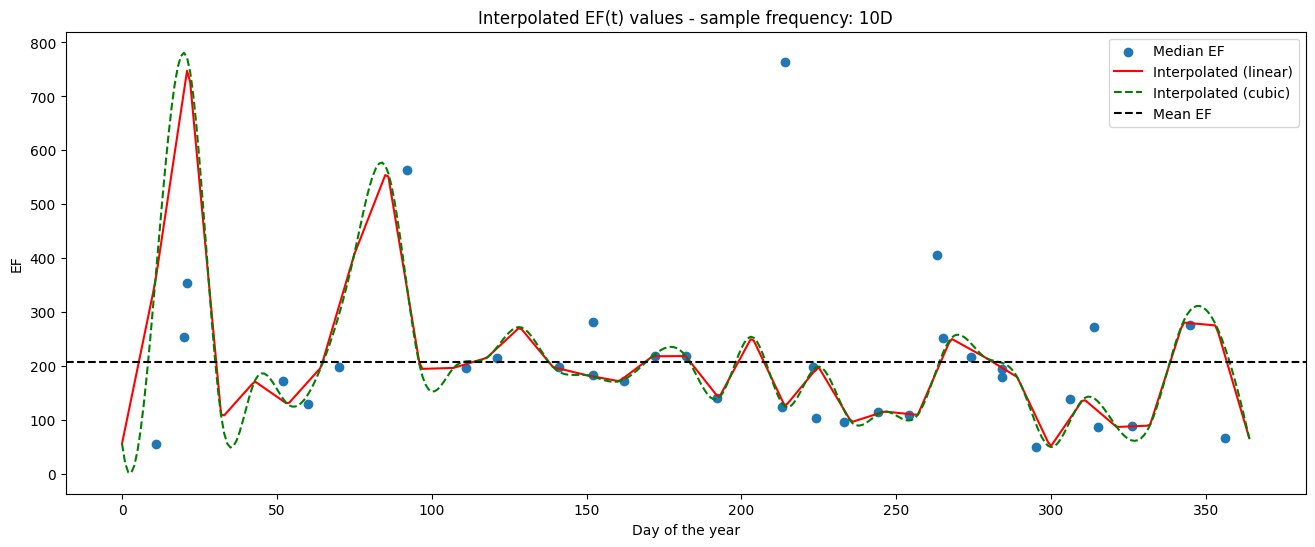

In [35]:
# Plot the interpolated EF values as a line whith linear and cubic interpolation using the function above
plt.figure(figsize=(16, 6))
plt.scatter(EF_grouped['day_of_year'], EF_grouped['EF'], label='Median EF')
plt.plot(np.arange(0, 365), interpolate_EF(EF_grouped['EF'], kind='linear'), label='Interpolated (linear)', linestyle='-', color='red')
plt.plot(np.arange(0, 365), interpolate_EF(EF_grouped['EF'], kind='cubic'), label='Interpolated (cubic)', linestyle='--', color='green')
# Add the mean EF value to the plot
plt.axhline(y=ef_mean, color='black', linestyle='--', label='Mean EF')
plt.xlabel('Day of the year')
plt.ylabel('EF')
plt.legend()
plt.title(f'Interpolated EF(t) values - sample frequency: {SAMPLE_FREQ}')
plt.show()

### Step 2

In [36]:
# Make a day of the year (1-365) column to the filtered_T data for calculating the theoretical monoterpene flux
filtered_T['day_of_year'] = filtered_T.index.dayofyear
filtered_T

,HYY_META.T168,day_of_year
Datetime,,
2011-01-01 11:00:00,-7.632167,1
2011-01-01 14:00:00,-7.787167,1
2011-01-02 11:00:00,-12.300667,2
2011-01-02 14:00:00,-11.426333,2
2011-01-03 11:00:00,-12.527500,3
...,...,...
2022-12-28 14:00:00,-1.361667,362
2022-12-29 11:00:00,-3.435667,363
2022-12-29 14:00:00,-2.892500,363


In [37]:
# Create a mapping between day_of_year and interplated coefficients
coefficients_mapping = dict(zip(range(1, 366), interpolated))

In [38]:
filtered_T['coeff'] = filtered_T['day_of_year'].map(coefficients_mapping)

In [39]:
filtered_T

,HYY_META.T168,day_of_year,coeff
Datetime,,,
2011-01-01 11:00:00,-7.632167,1,56.075676
2011-01-01 14:00:00,-7.787167,1,56.075676
2011-01-02 11:00:00,-12.300667,2,83.967741
2011-01-02 14:00:00,-11.426333,2,83.967741
2011-01-03 11:00:00,-12.527500,3,111.859806
...,...,...,...
2022-12-28 14:00:00,-1.361667,362,124.816543
2022-12-29 11:00:00,-3.435667,363,105.294037
2022-12-29 14:00:00,-2.892500,363,105.294037


In [40]:
# Drop the NaN values from the filtered_T data
filtered_T = filtered_T.dropna()

### Theoretical monoterpene (E) calculation

In [41]:
# Calculate the theoretical monoterpene flux using the interpolated coefficients
filtered_T['E'] = filtered_T['coeff'] / np.exp(0.09 * (25 - filtered_T['HYY_META.T168']))
# Calculate the theoretical monoterpene flux using just the mean EF value
filtered_T['E_mean'] = ef_mean / np.exp(0.09 * (25 - filtered_T['HYY_META.T168']))

/tmp/ipykernel_71106/2847831769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_T['E'] = filtered_T['coeff'] / np.exp(0.09 * (25 - filtered_T['HYY_META.T168']))
/tmp/ipykernel_71106/2847831769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_T['E_mean'] = ef_mean / np.exp(0.09 * (25 - filtered_T['HYY_META.T168']))


In [42]:
# Merge the filtered_MT and filtered_T data sets to get the difference between the estimate and the observation
theoretical_MT = pd.merge(filtered_MT, filtered_T, left_index=True, right_index=True, how='inner')

In [43]:
# Drop the columns that are not needed
theoretical_MT = theoretical_MT.drop(columns=['HYY_META.T168', 'day_of_year', 'coeff'])

In [44]:
theoretical_MT

,monoterpene_flux,E,E_mean
Datetime,,,
2011-03-08 11:00:00,NaN,20.700416,18.591491
2011-03-08 14:00:00,-4.22413,23.650489,21.241016
2011-03-09 11:00:00,34.33977,28.175683,23.343394
2011-03-09 14:00:00,NaN,35.400088,29.328772
2011-03-10 11:00:00,-2.15036,28.412850,21.846244
...,...,...,...
2022-12-28 14:00:00,-9.48310,11.638226,19.420982
2022-12-29 11:00:00,-11.67800,8.146161,16.114089
2022-12-29 14:00:00,-2.46000,8.554280,16.921399


In [45]:
theoretical_MT.describe()

,monoterpene_flux,E,E_mean
count,2928.000000,3209.000000,3209.000000
mean,47.074439,56.183670,59.782110
std,90.626287,45.908829,48.548035
min,-451.520000,2.831052,3.346915
25%,3.234495,23.207918,24.215405
50%,27.773000,45.262480,42.798755
75%,70.009190,73.882025,81.620382
max,1880.000000,313.683894,294.718014


In [46]:
# Save the Datetime index and E_mean as a columns to a csv file. Set the E_mean column name to 'E'
### NOTE! Saves the E_mean, not the interpolated E values. E is used to read the data to the main.ipynb ###
theoretical_MT['Datetime'] = theoretical_MT.index
theoretical_MT['E'] = theoretical_MT['E_mean']
theoretical_MT = theoretical_MT.drop(columns=['E_mean'])
theoretical_MT[['Datetime', 'E']].to_csv('baseline_monoterpene_mean.csv', index=False)

### NEE baseline

In [48]:
baseline_NEE = pd.read_csv('./../data/hyytiala_modelfluxes_2010-2019.csv')

Theretical NEE is calculated by: respiration_canopy + respiration_trunk + respiration_soil - photosynthesis

In [49]:
# Drop the columns that are not needed
baseline_NEE = baseline_NEE.drop(columns=['relative_humidity', 'soil_moisture', 'air_temp','soil_temp', 'irradiation', 'weather', 'co2', 'sample_day'])

In [50]:
# Drop the rows that have zero values in the photosynthesis, respiration_canopy,	respiration_trunk and respiration_soil
baseline_NEE = baseline_NEE[(baseline_NEE['photosynthesis'] != 0) & 
                            (baseline_NEE['respiration_canopy'] != 0) & 
                            (baseline_NEE['respiration_trunk'] != 0) & 
                            (baseline_NEE['respiration_soil'] != 0)]

In [51]:
# Calculate the theoretical NEE
baseline_NEE.loc[:, 'NEE_theoretical'] = (
    baseline_NEE['respiration_canopy'] + 
    baseline_NEE['respiration_trunk'] + 
    baseline_NEE['respiration_soil'] - 
    baseline_NEE['photosynthesis']
)

In [52]:
baseline_NEE

,time,photosynthesis,respiration_canopy,respiration_trunk,respiration_soil,NEE_theoretical
493,2010-01-11 23:30:00,8.200501e-07,0.022790,0.007597,0.600709,0.631095
495,2010-01-12 00:30:00,4.891754e-07,0.024962,0.008321,0.600813,0.634096
496,2010-01-12 01:00:00,6.849029e-07,0.027653,0.009218,0.600918,0.637787
498,2010-01-12 02:00:00,3.593141e-06,0.030007,0.010002,0.601647,0.641652
500,2010-01-12 03:00:00,1.025807e-05,0.033268,0.011089,0.602063,0.646411
...,...,...,...,...,...,...
169554,2019-12-31 13:30:00,4.086046e-01,0.168642,0.056214,0.804012,0.620263
169555,2019-12-31 14:00:00,2.702518e-01,0.164384,0.054795,0.803402,0.752329
169556,2019-12-31 14:30:00,1.312732e-01,0.144745,0.048248,0.804378,0.866097
169557,2019-12-31 15:00:00,3.444579e-02,0.122583,0.040861,0.806208,0.935206


### Combining of theoretical and measurement NEE datasets

In [53]:
# load the observed NEE data
observed_NEE = pd.read_csv('./../data/GPP_NEE_flux_2001-2022.csv')

In [54]:
# Keep only the rows where NEE_gapfilling_method is 0
observed_NEE = observed_NEE[observed_NEE['NEE_gapfilling_method'] == 0]

In [55]:
# Drop the Unnamed:0, NEE_gapfillling_methdo and GPP columns
observed_NEE = observed_NEE.drop(columns=['Unnamed: 0', 'NEE_gapfilling_method', 'GPP'])
# Convert the Datetime column to datetime object and set it as index
observed_NEE['Datetime'] = pd.to_datetime(observed_NEE['Datetime'])
observed_NEE.set_index('Datetime', inplace=True)

In [56]:
# Drop the photosynthesis, respiration_canopy, respiration_trunk and respiration_soil columns from the baseline_NEE data
baseline_NEE = baseline_NEE.drop(columns=['photosynthesis', 'respiration_canopy', 'respiration_trunk', 'respiration_soil'])
# Set the time column to datetime object and set it as index
baseline_NEE['time'] = pd.to_datetime(baseline_NEE['time'])
baseline_NEE.set_index('time', inplace=True)

In [57]:
# Observed NEE data and baseline NEE data have different time ranges
# We need to filter the observed NEE data to match the time range of the baseline NEE data
observed_NEE = observed_NEE[(observed_NEE.index >= baseline_NEE.index[0]) & (observed_NEE.index <= baseline_NEE.index[-1])]

In [58]:
# Merge the observed NEE data and the baseline NEE data
# If there are missing values in each data set, fill them with NaN
combined_NEE = pd.merge(baseline_NEE, observed_NEE, left_index=True, right_index=True, how='outer')

In [59]:
combined_NEE.describe()

,NEE_theoretical,NEE
count,107889.000000,94901.000000
mean,-2.327767,-2.205568
std,5.494001,5.181722
min,-19.047672,-24.984000
25%,-6.170656,-4.978000
50%,0.169801,-0.015000
75%,1.338686,0.995000
max,8.531268,14.828000


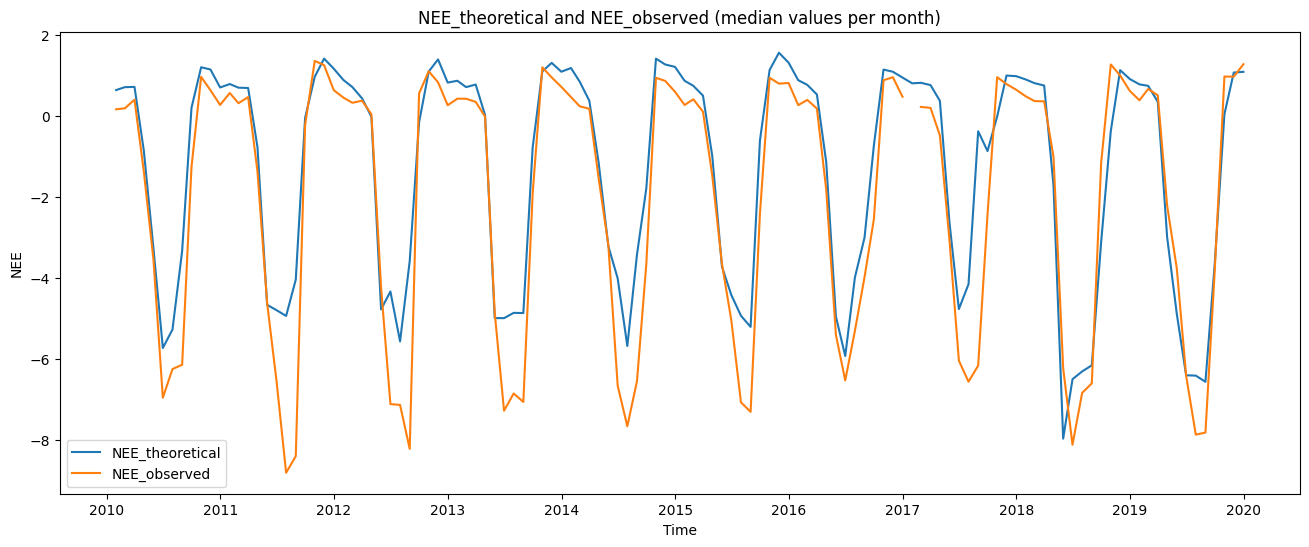

In [60]:
# Group the data by month and calculate the mean of the NEE_theoretical and NEE columns.
combined_NEE_grouped = combined_NEE.resample('ME').median()
# Make a plot of the NEE_theoretical and NEE columns
plt.figure(figsize=(16, 6))
plt.plot(combined_NEE_grouped.index, combined_NEE_grouped['NEE_theoretical'], label='NEE_theoretical')
plt.plot(combined_NEE_grouped.index, combined_NEE_grouped['NEE'], label='NEE_observed')
plt.xlabel('Time')
plt.ylabel('NEE')
plt.legend()
plt.title('NEE_theoretical and NEE_observed (median values per month)')
plt.show()


In [61]:
# calculate the difference between the observed and theoretical NEE
combined_NEE['NEE_difference'] = combined_NEE['NEE'] - combined_NEE['NEE_theoretical']

In [62]:
combined_NEE.describe()

,NEE_theoretical,NEE,NEE_difference
count,107889.000000,94901.000000,69048.000000
mean,-2.327767,-2.205568,0.507580
std,5.494001,5.181722,2.267534
min,-19.047672,-24.984000,-14.083164
25%,-6.170656,-4.978000,-0.721452
50%,0.169801,-0.015000,0.126395
75%,1.338686,0.995000,1.599368
max,8.531268,14.828000,25.107502


In [63]:
# Save the combined_NEE data to a csv file
combined_NEE["NEE_theoretical"].to_csv("baseline_NEE.csv")